# <font color='blue'>Introduction to Wavelets</font>

---

<img src="images/cea_logo.png" width="100" align="right">


> Author: **Samuel Farrens**

> Year: **2016**

> Version: **1.0**

> Email: **[samuel.farrens@cea.fr](mailto:samuel.farrens@cea.fr)**

> Web: **[CosmoStat Website](http://www.cosmostat.org/)**


## <font color='blue'>Contents</font>

---
 
1. [Set-Up](#Set-Up)
1. [Introduction](#Introduction)

## <font color='blue'>Set-Up</font>

---

Here we will import a couple of packages that we will need throughout the notebook.

In [1]:
# Tell Jupyter to display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np           

# Import the pyplot package from matplotlib with the alias plt.
import matplotlib.pyplot as plt  
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Import some tools from scipy.
from scipy import fftpack, signal

# SOME USEFUL FUNCTIONS

# Function to calculate an orthonormal descrete cosine transform.
def fft(signal):

    return fftpack.fft(signal)

# Function to calculate an orthonormal descrete cosine transform.
def ifft(signal):

    return fftpack.ifft(signal)

def hide_axes(axis):
    
    axis.xaxis.set_ticklabels([])
    axis.yaxis.set_ticklabels([])

## <font color='blue'>Introduction</font>

---



## <font color='blue'>Fourier Transform</font>

---

### <font color='green'>Standard FFT</font>


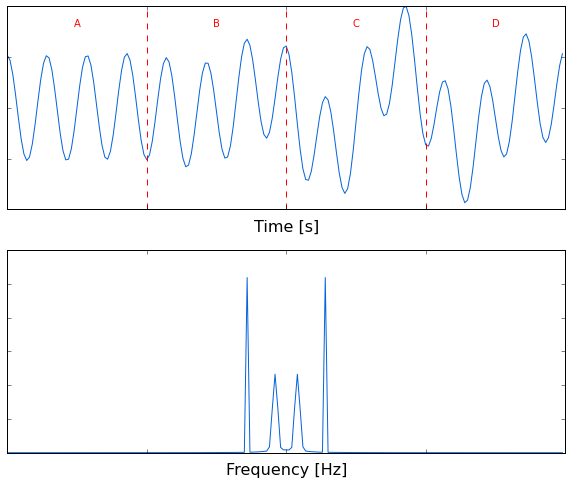

In [24]:
# Define the signal
t = np.linspace(-1, 1, 200, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
sig /= max(sig)

# Get the Fourier transform of the signal
sig_fft = np.abs(fftpack.fftshift(fft(sig)))

# Display
ax1 = plt.subplot(211)
ax1.plot(t, sig, '-', color='#0764DB')
ax1.plot([-0.5, -0.5], [-1, 1], 'r--')
ax1.plot([0.0, 0.0], [-1, 1], 'r--')
ax1.plot([0.5, 0.5], [-1, 1], 'r--')
plt.text(-0.76, 0.8, 'A', color='red')
plt.text(-0.26, 0.8, 'B', color='red')
plt.text(0.24, 0.8, 'C', color='red')
plt.text(0.74, 0.8, 'D', color='red')
ax1.set_xlabel('Time [s]', fontsize=16)
hide_axes(ax1)
ax2 = plt.subplot(212)
ax2.plot(t, sig_fft, '-', color='#0764DB')
ax2.set_xlabel('Frequency [Hz]', fontsize=16)
hide_axes(ax2)
plt.show()

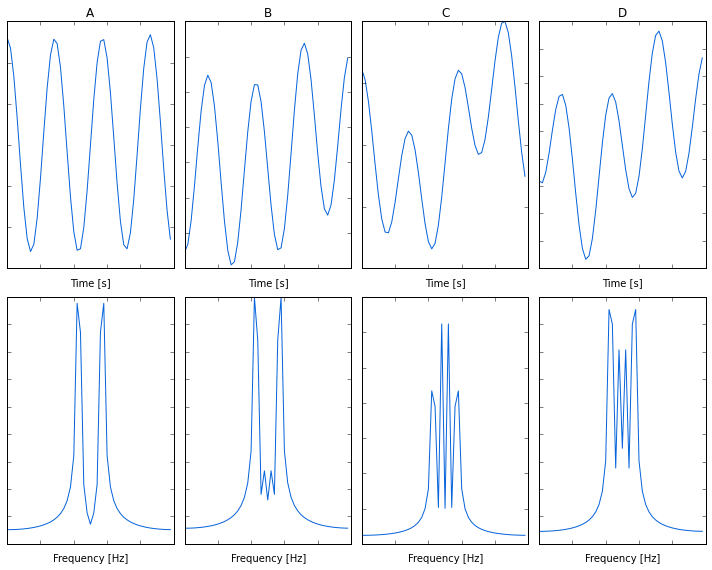

In [25]:
# Slice the signal into four pieces
slice_size = t.size / 4
slices = [slice(i * slice_size, (i + 1) * slice_size) for i in range(4)]
titles = ('A', 'B', 'C', 'D')

# Display
for i in range(len(slices)):
    sig_fft = np.abs(fftpack.fftshift(fft(sig[slices[i]])))
    ax = plt.subplot(2, 4, i + 1)
    ax.plot(t[slices[i]], sig[slices[i]], '-', color='#0764DB')
    ax.set_xlabel('Time [s]')
    ax.set_title(titles[i])
    hide_axes(ax)
    ax = plt.subplot(2, 4, i + 5)
    ax.plot(t[slices[i]], sig_fft, '-', color='#0764DB')
    ax.set_xlabel('Frequency [Hz]')
    hide_axes(ax)
plt.tight_layout()
plt.show()

What happens if we make the windows smaller?

### <font color='green'>Uncertainty Principle</font>

The **Heisenberg–Gabor limit**, 

$$\Delta t \Delta \omega \geq \frac{1}{2},$$

an interpretation of the uncertainty principle, shows that it is not possible to simultaneously sharply localize a signal in both the time domain and frequency domain.

In other words we will always need to make a trade-off between time information and frequency information, but is the best way to preserve as much of both as possible?